# ValueInvestor

Importing necessary libraries

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import tqdm
import tensorflow as ts
import plotly as py 
import warnings
warnings.filterwarnings('ignore')

Importing the data

In [19]:
# Load all sheets into a dictionary of DataFrames
file_path = 'data/2020Q1Q2Q3Q4-2021Q1.xlsx' 
xls = pd.ExcelFile(file_path)
sheets = xls.sheet_names

# Load each sheet into a dictionary
data = {sheet: xls.parse(sheet) for sheet in sheets}

# Check one sample
data[sheets[0]].head()
# print({sheet for sheet in sheets})

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [20]:
print({sheet for sheet in sheets})

{'Brazil - Minerva SABrazil (BEEF', 'Colombia - Cementos Argos SA (C', 'South Korea - Dongkuk Steel Mil', 'South Africa - Impala Platinum ', 'Russia - Sberbank Rossii PAO (S', 'Turkey - Koc Holding AS (KCHOL)', 'Argentina - Pampa Energia SA (P', 'Egypt - Medinet Nasr Housing (M'}


### Data cleaning

In [21]:
def preprocess(df):
    df = df.copy()

    # To drop the last(any) row(s) where any column starts with a summary keyword
    summary_keywords = ['Highest:', 'Lowest:', 'Difference:', 'Average:']

    def is_summary_row(row):
        return any(isinstance(val, str) and any(val.strip().startswith(key) for key in summary_keywords) for val in row)

    df = df[~df.apply(is_summary_row, axis=1)]

    # Change Date column to datetime format, drop any null value, and sort data with respect to date.
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[df['Date'].notnull()]
    df = df.sort_values('Date')

    # Remove non-numeric symbols from data.
    def parse_volume(val):
        val = str(val).replace(',', '').replace('%', '')
        if 'K' in val:
            return float(val.replace('K', '')) * 1_000
        elif 'M' in val:
            return float(val.replace('M', '')) * 1_000_000
        else:
            try:
                return float(val)
            except:
                return None

    df['Vol.'] = df['Vol.'].apply(parse_volume)
    df['Change %'] = df['Change %'].astype(str).str.replace('%', '').astype(float)

    # Drop rows with null price value.
    df = df.dropna(subset=['Price'])

    return df

cleaned_data = {k: preprocess(v) for k, v in data.items()}

Printing one sheet to see if data is sorted.

In [22]:
print(cleaned_data[sheets[0]])

          Date   Price    Open    High     Low        Vol.  Change %
310 2020-01-03     255  255.99  258.19   253.7  35850000.0    0.0010
309 2020-01-06   253.9  254.75  254.84   251.4  22350000.0   -0.0043
308 2020-01-08  259.15  253.57  259.15  253.03  40820000.0    0.0207
307 2020-01-09  257.99   259.4  261.76  257.01  38330000.0   -0.0045
306 2020-01-10  258.19  257.86  259.25  256.88  18850000.0    0.0008
..         ...     ...     ...     ...     ...         ...       ...
4   2021-03-25  286.66   286.5  287.03  283.85  35220000.0    0.0030
3   2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2   2021-03-29   293.3  289.72  294.09  289.26  43680000.0    0.0071
1   2021-03-30  293.25  294.86  295.72   291.5  38810000.0   -0.0002
0   2021-03-31  291.02     294  294.42  290.26  47000000.0   -0.0076

[311 rows x 7 columns]


#### Add Derived Features

Daily return, Rolling Moving Averages (e.g. 5, 20 days), and Weekly and Monthly bins

In [23]:
def add_features(df):
    df = df.copy()
    df['Return'] = df['Price'].pct_change()
    df['MA_5'] = df['Price'].rolling(window=5).mean()
    df['MA_20'] = df['Price'].rolling(window=20).mean()
    df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
    df['Month'] = df['Date'].dt.to_period('M').apply(lambda r: r.start_time)
    return df

featured_data = {k: add_features(v) for k, v in cleaned_data.items()}


Printing featured data

In [24]:
print(featured_data[sheets[0]])

          Date   Price    Open    High     Low        Vol.  Change %  \
310 2020-01-03     255  255.99  258.19   253.7  35850000.0    0.0010   
309 2020-01-06   253.9  254.75  254.84   251.4  22350000.0   -0.0043   
308 2020-01-08  259.15  253.57  259.15  253.03  40820000.0    0.0207   
307 2020-01-09  257.99   259.4  261.76  257.01  38330000.0   -0.0045   
306 2020-01-10  258.19  257.86  259.25  256.88  18850000.0    0.0008   
..         ...     ...     ...     ...     ...         ...       ...   
4   2021-03-25  286.66   286.5  287.03  283.85  35220000.0    0.0030   
3   2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159   
2   2021-03-29   293.3  289.72  294.09  289.26  43680000.0    0.0071   
1   2021-03-30  293.25  294.86  295.72   291.5  38810000.0   -0.0002   
0   2021-03-31  291.02     294  294.42  290.26  47000000.0   -0.0076   

       Return     MA_5     MA_20       Week      Month  
310       NaN      NaN       NaN 2019-12-30 2020-01-01  
309 -0.004314      Na

### Visualization

##### Moving Average

Moving average smooths out noise to reveal trends. Takes the average of the last n days (say 5 or 20). Helps you see uptrends or downtrends

Visualizing moving average for "Russia - Sberbank Rossii PAO (S)"

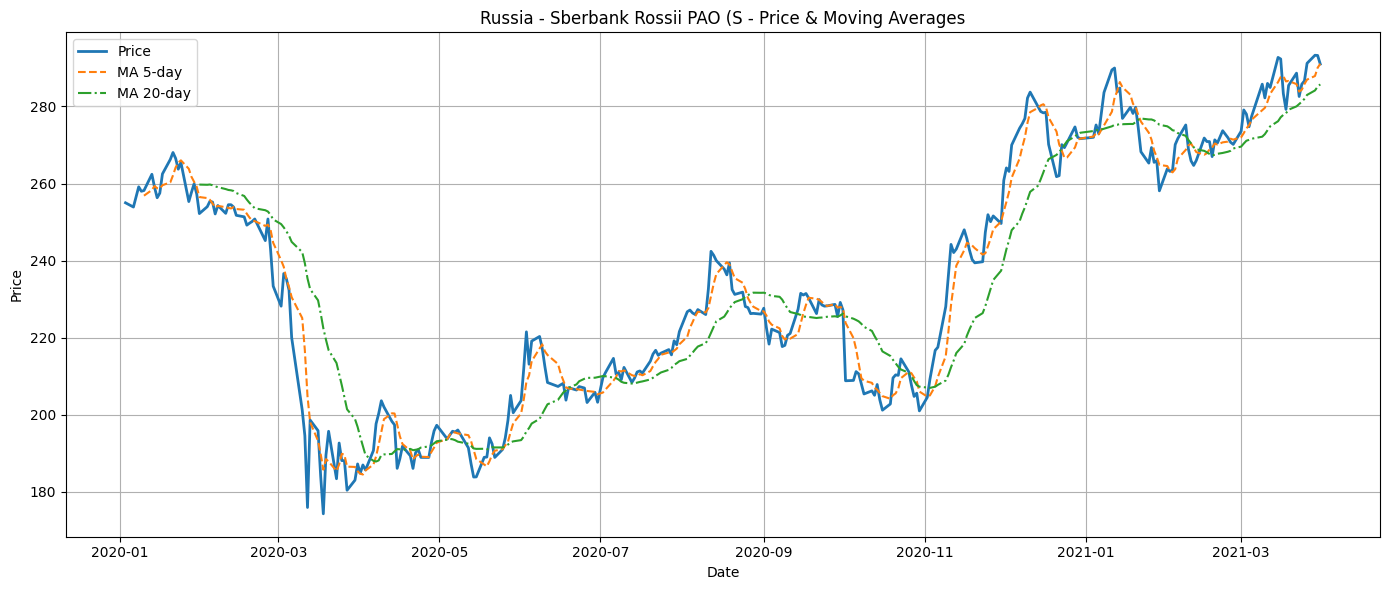

In [25]:
def plot_moving_average(df, company_name):
    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['Price'], label='Price', linewidth=2)
    plt.plot(df['Date'], df['MA_5'], label='MA 5-day', linestyle='--')
    plt.plot(df['Date'], df['MA_20'], label='MA 20-day', linestyle='-.')
    plt.title(f'{company_name} - Price & Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for a specific company
plot_moving_average(featured_data[sheets[0]], sheets[0]) 


Price vs Volume

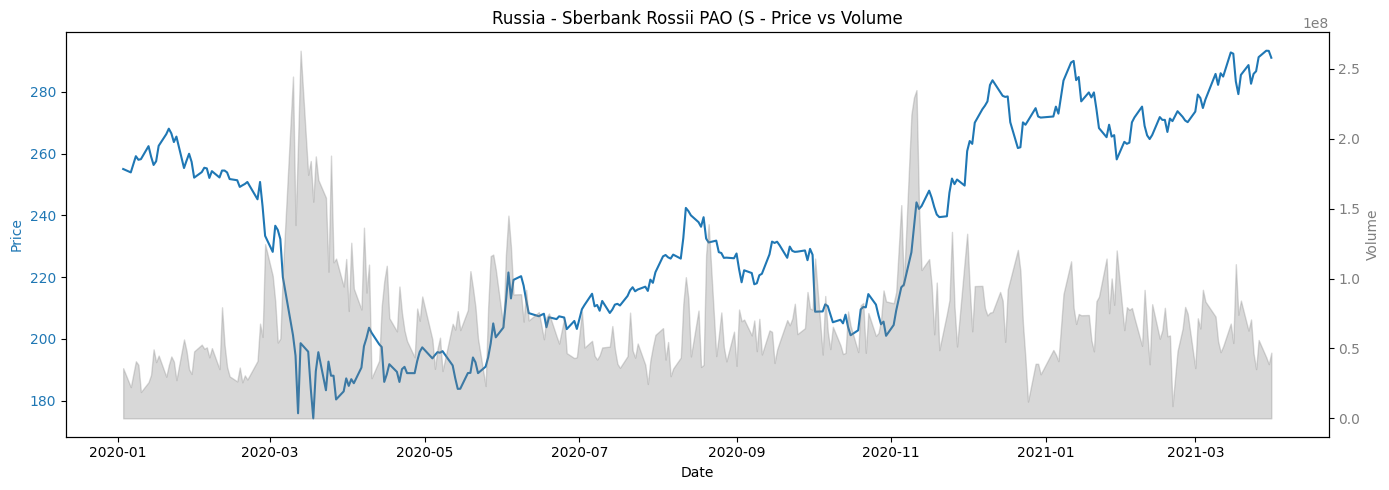

In [26]:
def plot_price_volume(df, company_name):
    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(df['Date'], df['Price'], color='tab:blue', label='Price')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # second y-axis
    ax2.set_ylabel('Volume', color='tab:gray')
    ax2.fill_between(df['Date'], df['Vol.'], alpha=0.3, color='gray', label='Volume')
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    plt.title(f'{company_name} - Price vs Volume')
    fig.tight_layout()
    plt.show()

plot_price_volume(featured_data[sheets[0]], sheets[0]) 


### Exponential Smoothing

Exponential Smoothing gives more weight to recent data, making it effective for short-term forecasting. It’s simple, fast, and works well for trend detection in financial time series.

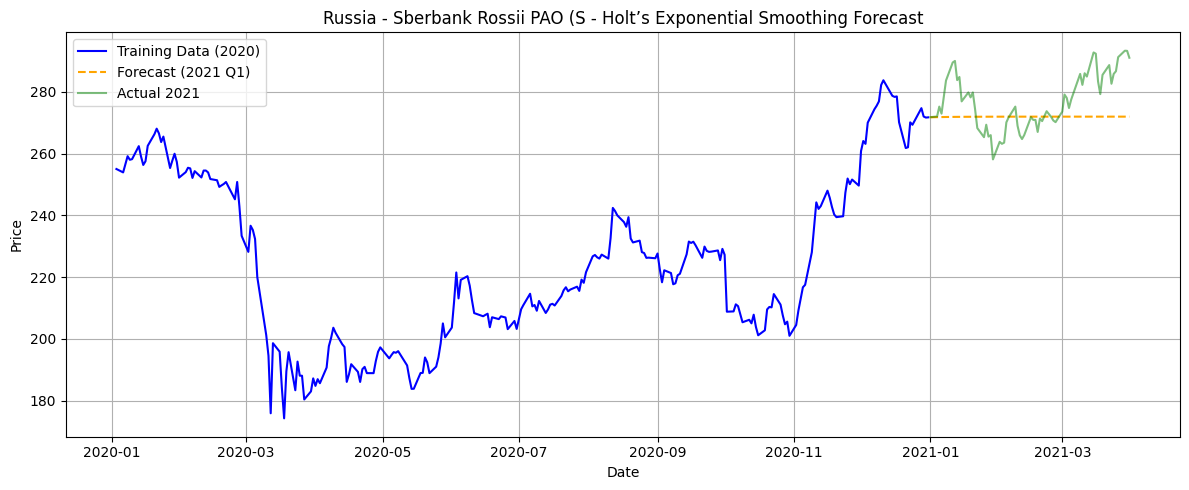

Forecast Accuracy for Russia - Sberbank Rossii PAO (S (Q1 2021):
  RMSE : 10.28
  MAPE : 2.85%


(2021-01-01    271.740074
 2021-01-02    271.758428
 2021-01-03    271.775208
 2021-01-04    271.790551
 2021-01-05    271.804578
                  ...    
 2021-03-27    271.954095
 2021-03-28    271.954104
 2021-03-29    271.954112
 2021-03-30    271.954119
 2021-03-31    271.954126
 Freq: D, Length: 90, dtype: float64,
 10.275514146871844,
 2.852228222642814)

In [27]:
def evaluate_forecast(forecast, actual):
    actual = actual.loc[forecast.index]
    valid_index = actual.notna() & forecast.notna()
    forecast = forecast[valid_index]
    actual = actual[valid_index]
    
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # %
    return rmse, mape

def exponential_smoothing_forecast(df, company_name='Company', forecast_days=90):
    df = df.copy()

    # 1. Fix the 'Date' column to proper datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])

    # 2. Clean and convert Price column to float
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df = df.dropna(subset=['Price'])

    # 3. Set Date as index and ensure daily frequency
    df = df.set_index('Date').sort_index()
    df = df.asfreq('D')  # fill weekends/holidays as missing
    df['Price'] = df['Price'].interpolate(method='linear')

    # 4. Training data (2020)
    train_df = df[df.index.year == 2020]['Price'].astype(float).dropna()

    # 5. Fit Holt's model (Exponential Smoothing with trend)
    model = ExponentialSmoothing(train_df, trend='add', seasonal=None, damped_trend=True)
    fit = model.fit()

    # 6. Forecast next days (e.g., 90 days = Q1 2021)
    forecast = fit.forecast(forecast_days)

    # 7. Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(train_df.index, train_df, label='Training Data (2020)', color='blue')
    plt.plot(forecast.index, forecast, label='Forecast (2021 Q1)', linestyle='--', color='orange')

    # Actual 2021 data for comparison
    actual_2021 = df[(df.index.year == 2021) & (df.index <= forecast.index[-1])]['Price']
    if not actual_2021.empty:
        plt.plot(actual_2021.index, actual_2021, label='Actual 2021', color='green', alpha=0.5)

    plt.title(f'{company_name} - Holt’s Exponential Smoothing Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 8. Evaluate forecast
    if not actual_2021.empty:
        rmse, mape = evaluate_forecast(forecast, actual_2021)
        print(f'Forecast Accuracy for {company_name} (Q1 2021):')
        print(f'  RMSE : {rmse:.2f}')
        print(f'  MAPE : {mape:.2f}%')
        return forecast, rmse, mape

    return forecast, NONE, NONE
exponential_smoothing_forecast(featured_data[sheets[0]], company_name=sheets[0])

##### Exponential smoothing for all sheets.


📈 Processing: Russia - Sberbank Rossii PAO (S


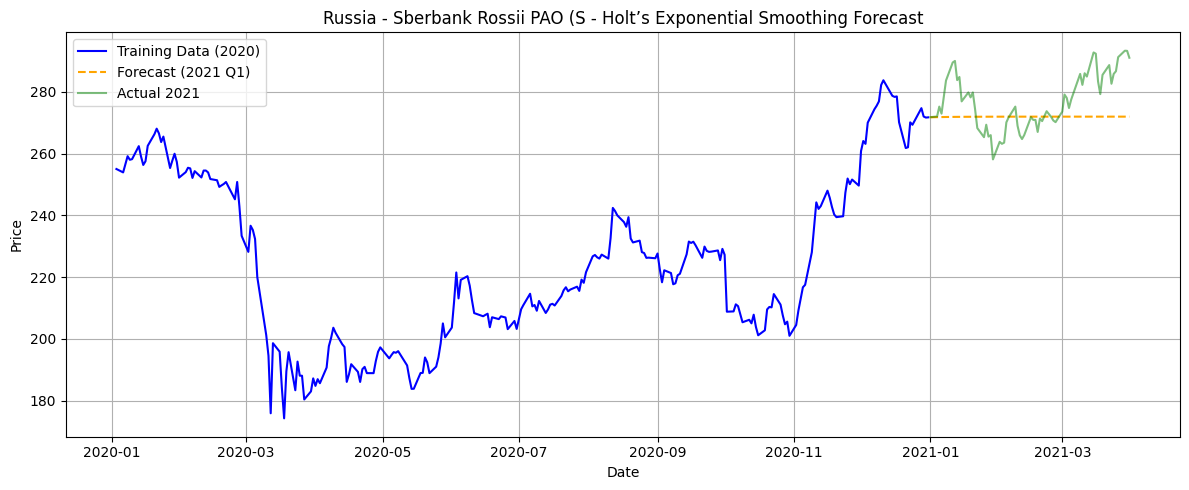

Forecast Accuracy for Russia - Sberbank Rossii PAO (S (Q1 2021):
  RMSE : 10.28
  MAPE : 2.85%

📈 Processing: Turkey - Koc Holding AS (KCHOL)


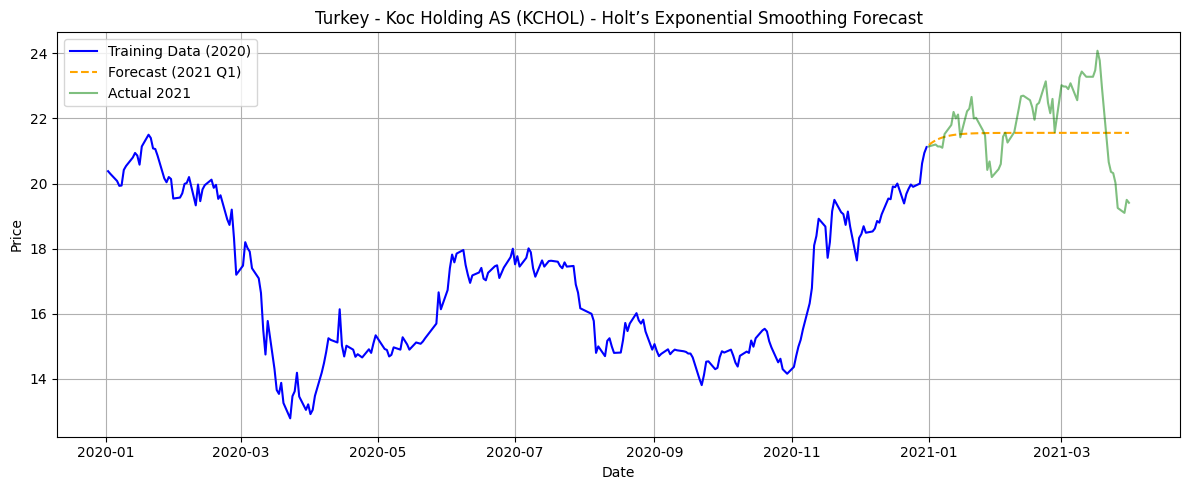

Forecast Accuracy for Turkey - Koc Holding AS (KCHOL) (Q1 2021):
  RMSE : 1.17
  MAPE : 4.36%

📈 Processing: Egypt - Medinet Nasr Housing (M


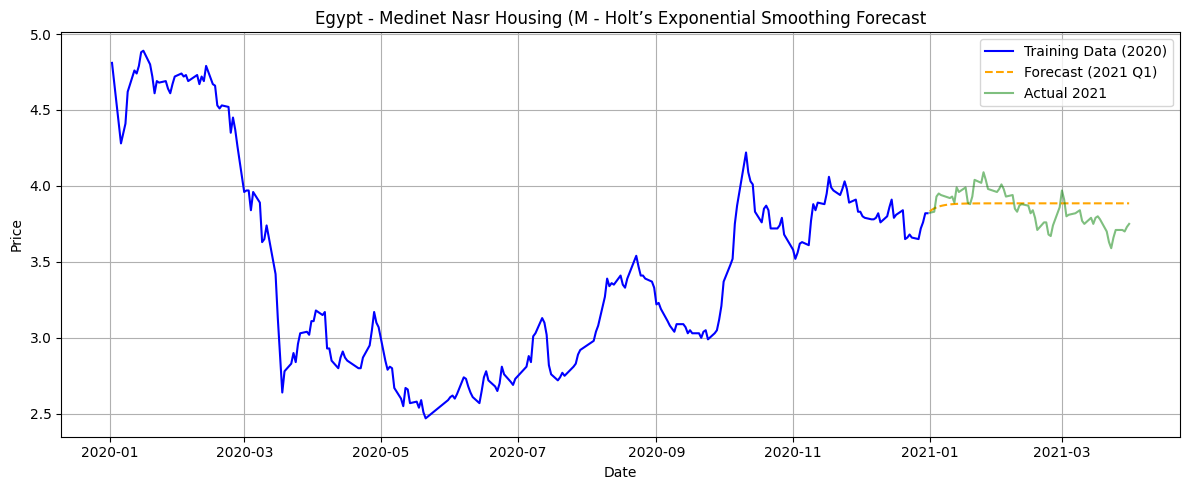

Forecast Accuracy for Egypt - Medinet Nasr Housing (M (Q1 2021):
  RMSE : 0.12
  MAPE : 2.56%

📈 Processing: Brazil - Minerva SABrazil (BEEF


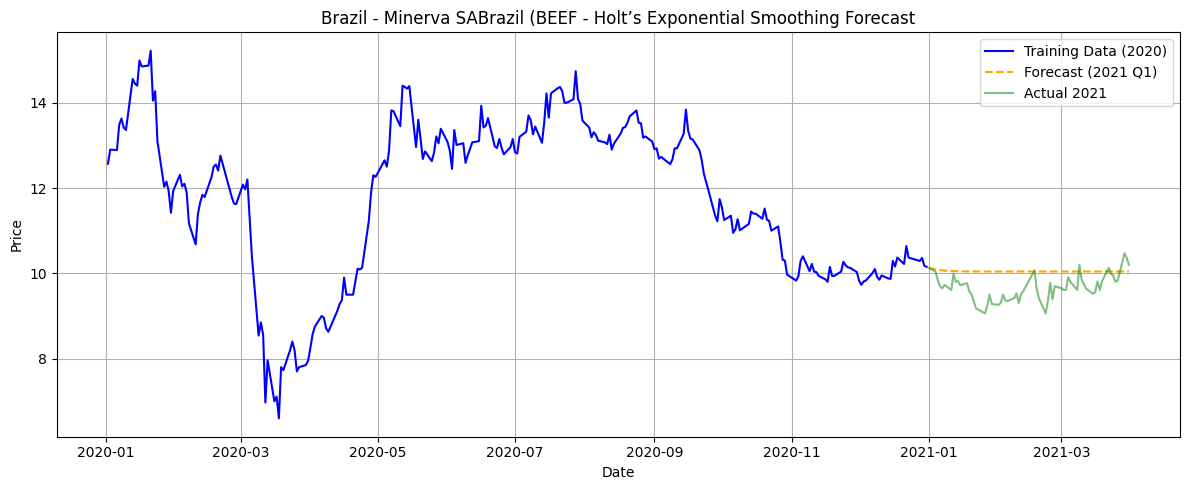

Forecast Accuracy for Brazil - Minerva SABrazil (BEEF (Q1 2021):
  RMSE : 0.49
  MAPE : 4.44%

📈 Processing: Argentina - Pampa Energia SA (P


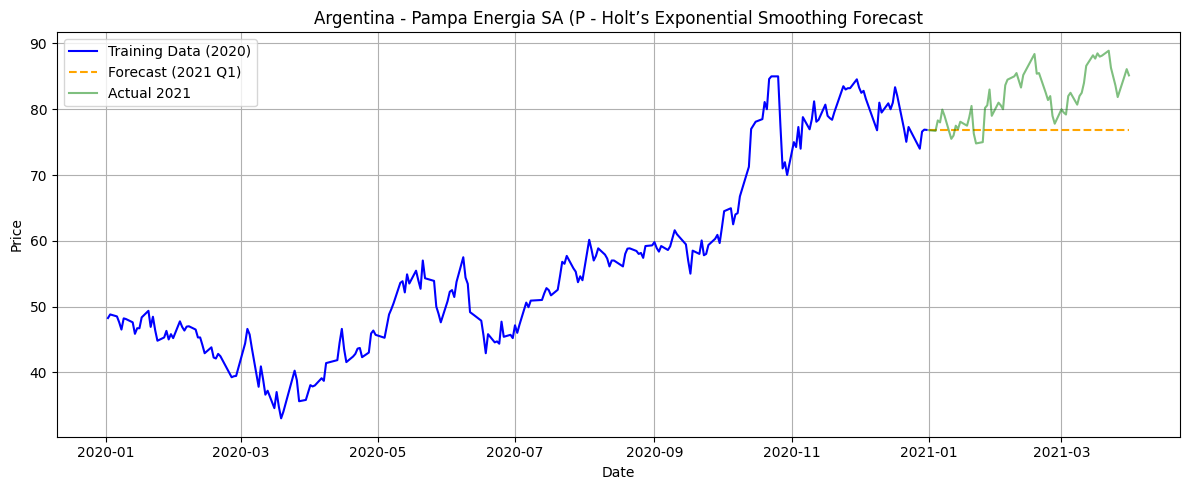

Forecast Accuracy for Argentina - Pampa Energia SA (P (Q1 2021):
  RMSE : 6.45
  MAPE : 6.29%

📈 Processing: Colombia - Cementos Argos SA (C


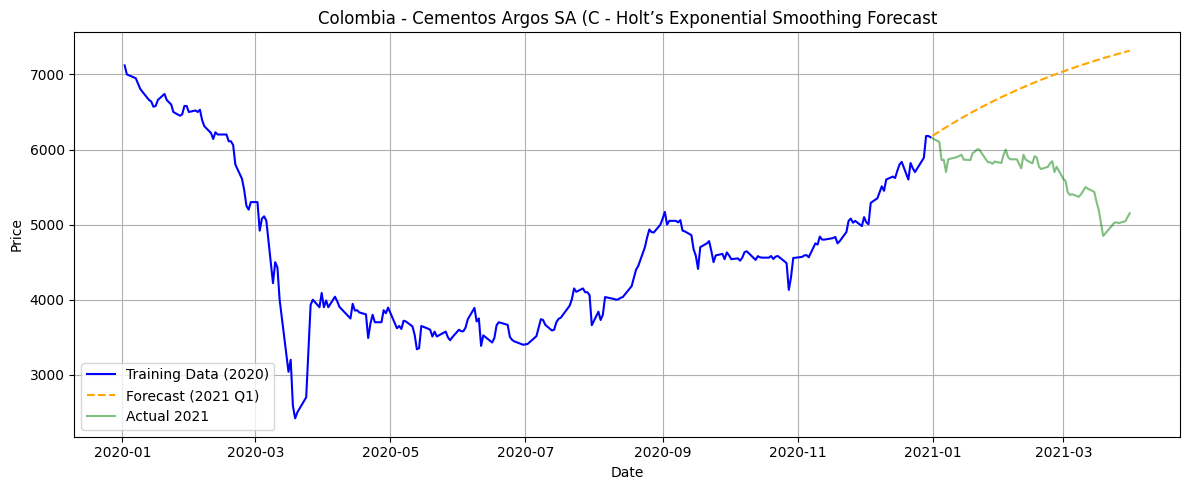

Forecast Accuracy for Colombia - Cementos Argos SA (C (Q1 2021):
  RMSE : 1342.39
  MAPE : 21.66%

📈 Processing: South Africa - Impala Platinum 


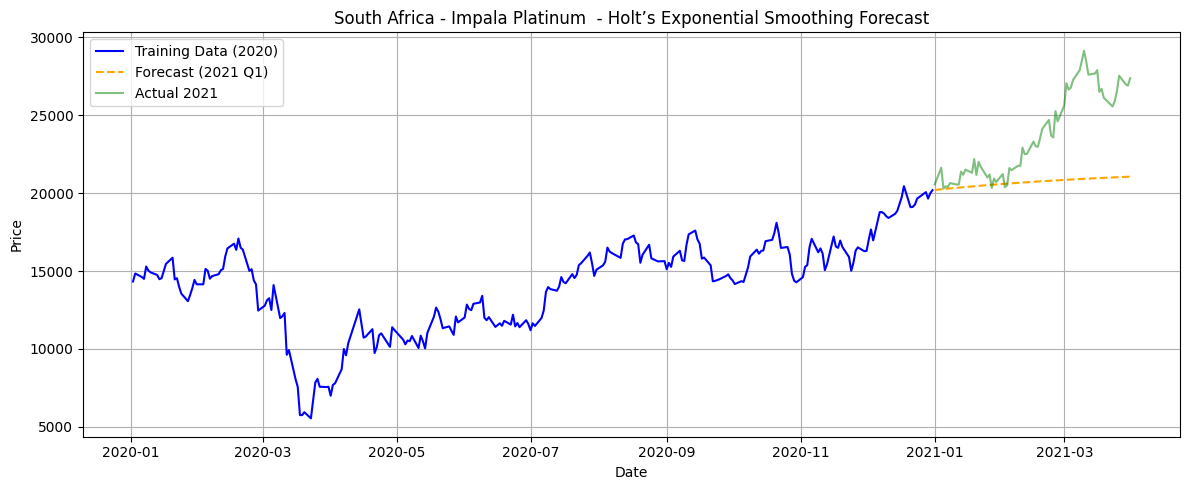

Forecast Accuracy for South Africa - Impala Platinum  (Q1 2021):
  RMSE : 3934.89
  MAPE : 11.81%

📈 Processing: South Korea - Dongkuk Steel Mil


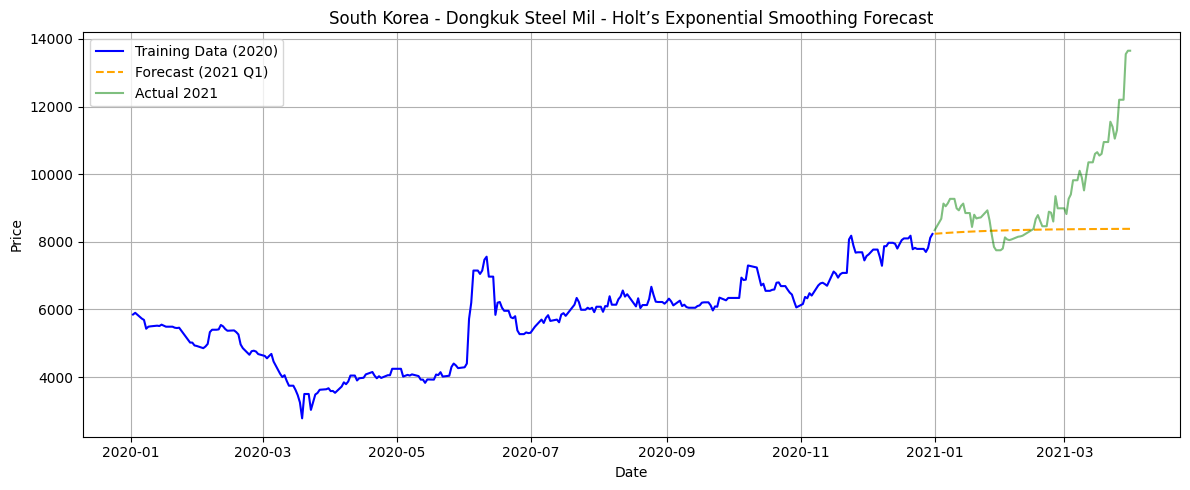

Forecast Accuracy for South Korea - Dongkuk Steel Mil (Q1 2021):
  RMSE : 1651.19
  MAPE : 10.62%


In [28]:
# Store results
forecast_results = {}
accuracy_summary = []

for company_name, df in featured_data.items():
    print(f'\n📈 Processing: {company_name}')
    try:
        forecast, rmse, mape = exponential_smoothing_forecast(df, company_name=company_name, forecast_days=90)
        forecast_results[company_name] = forecast
        accuracy_summary.append({
            'Company': company_name,
            'RMSE': rmse,
            'MAPE': mape
        })
    except Exception as e:
        print(f'❌ Failed for {company_name}: {e}')

### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a classic time series forecasting model suitable for univariate series like stock prices.

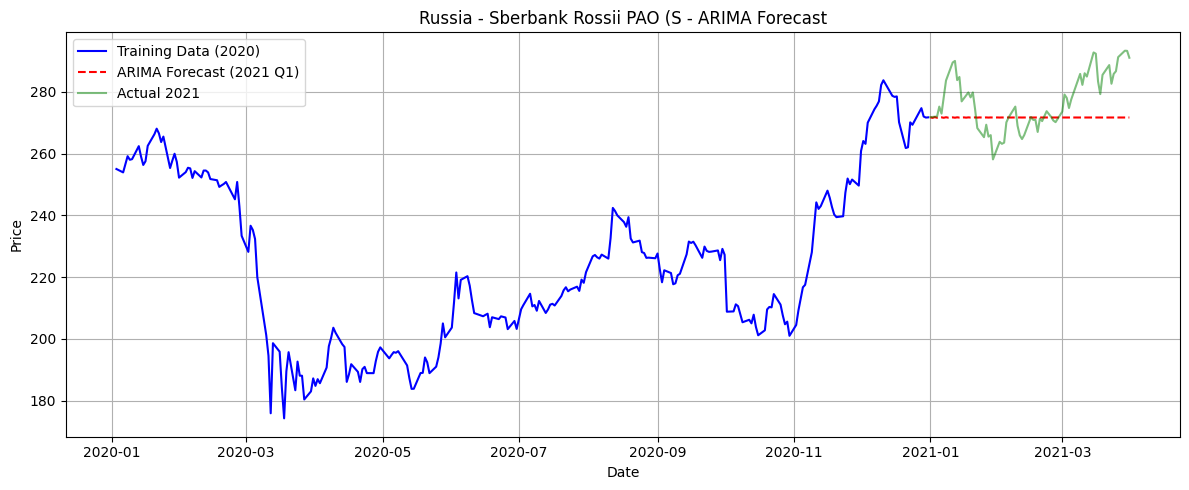

ARIMA Forecast Accuracy for Russia - Sberbank Rossii PAO (S (Q1 2021):
  RMSE : 10.40
  MAPE : 2.88%


In [29]:
def arima_forecast(df, company_name='Company', forecast_days=90):
    df = df.copy()

    # 1. Date & Price cleanup
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df = df.dropna(subset=['Price'])

    # 2. Index and interpolation
    df = df.set_index('Date').sort_index()
    df = df.asfreq('D')
    df['Price'] = df['Price'].interpolate(method='linear')

    # 3. Training data (2020 only)
    train = df[df.index.year == 2020]['Price']

    # 4. Fit ARIMA model
    model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')
    model_fit = model.fit(train)

    # 5. Forecast future days
    forecast = model.predict(n_periods=forecast_days)
    forecast_index = pd.date_range(start='2021-01-01', periods=forecast_days, freq='D')
    forecast_series = pd.Series(forecast, index=forecast_index)

    # 6. Plot
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label='Training Data (2020)', color='blue')
    plt.plot(forecast_series.index, forecast_series, label='ARIMA Forecast (2021 Q1)', linestyle='--', color='red')

    actual_2021 = df[(df.index.year == 2021) & (df.index <= forecast_series.index[-1])]['Price']
    if not actual_2021.empty:
        plt.plot(actual_2021.index, actual_2021, label='Actual 2021', color='green', alpha=0.5)

    plt.title(f'{company_name} - ARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 7. Evaluate
    if not actual_2021.empty:
        actual = actual_2021.loc[forecast_series.index].dropna()
        forecast_trimmed = forecast_series.loc[actual.index]
        rmse = np.sqrt(mean_squared_error(actual, forecast_trimmed))
        mape = mean_absolute_percentage_error(actual, forecast_trimmed) * 100
        print(f'ARIMA Forecast Accuracy for {company_name} (Q1 2021):')
        print(f'  RMSE : {rmse:.2f}')
        print(f'  MAPE : {mape:.2f}%')
        return forecast_series, rmse, mape

    return forecast_series, None, None
forecast, rmse, mape = arima_forecast(featured_data[sheets[0]], company_name=sheets[0])

##### ARIMA for all sheets.


 Running ARIMA Forecast for: Russia - Sberbank Rossii PAO (S


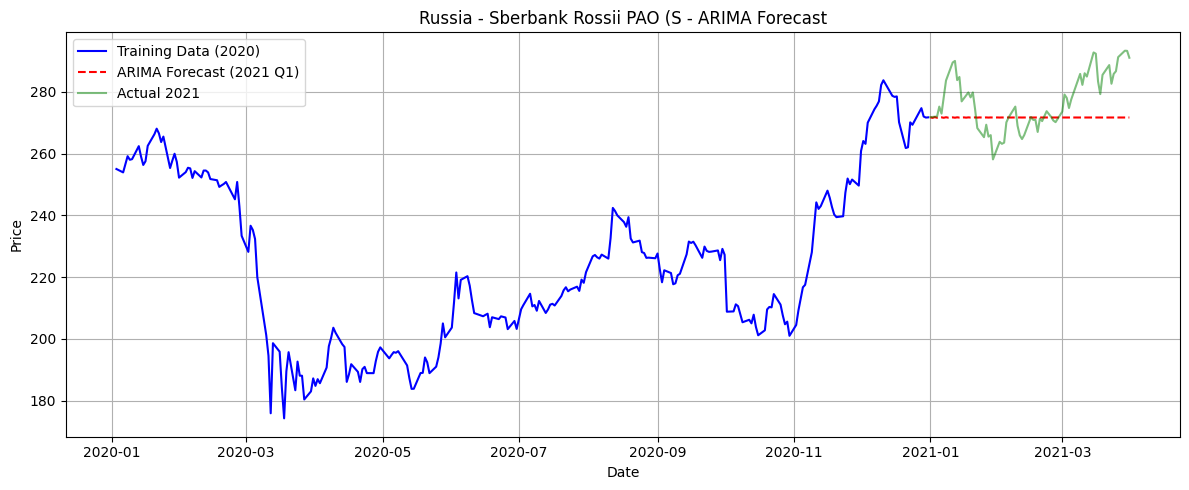

ARIMA Forecast Accuracy for Russia - Sberbank Rossii PAO (S (Q1 2021):
  RMSE : 10.40
  MAPE : 2.88%

 Running ARIMA Forecast for: Turkey - Koc Holding AS (KCHOL)


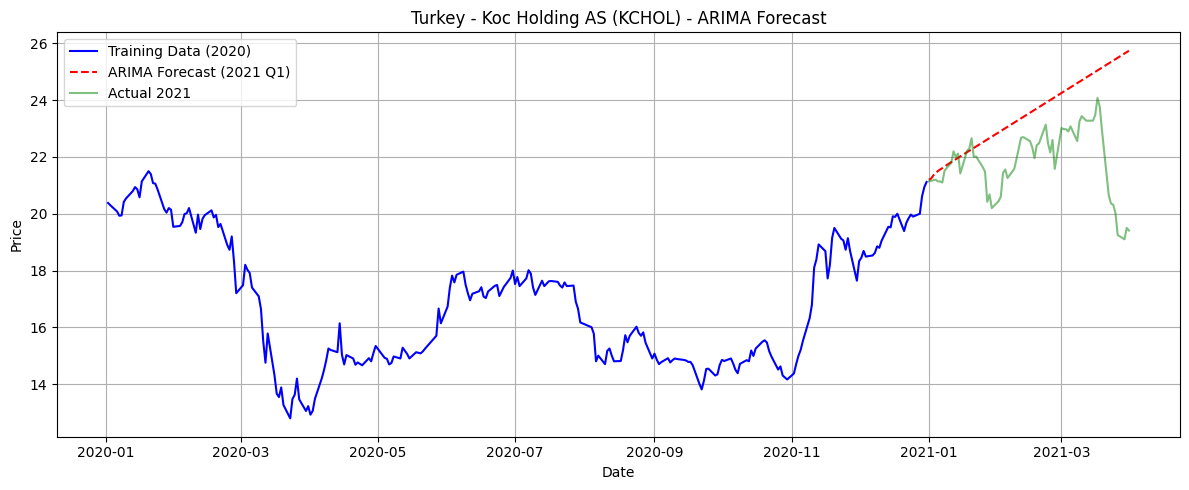

ARIMA Forecast Accuracy for Turkey - Koc Holding AS (KCHOL) (Q1 2021):
  RMSE : 2.38
  MAPE : 8.14%

 Running ARIMA Forecast for: Egypt - Medinet Nasr Housing (M


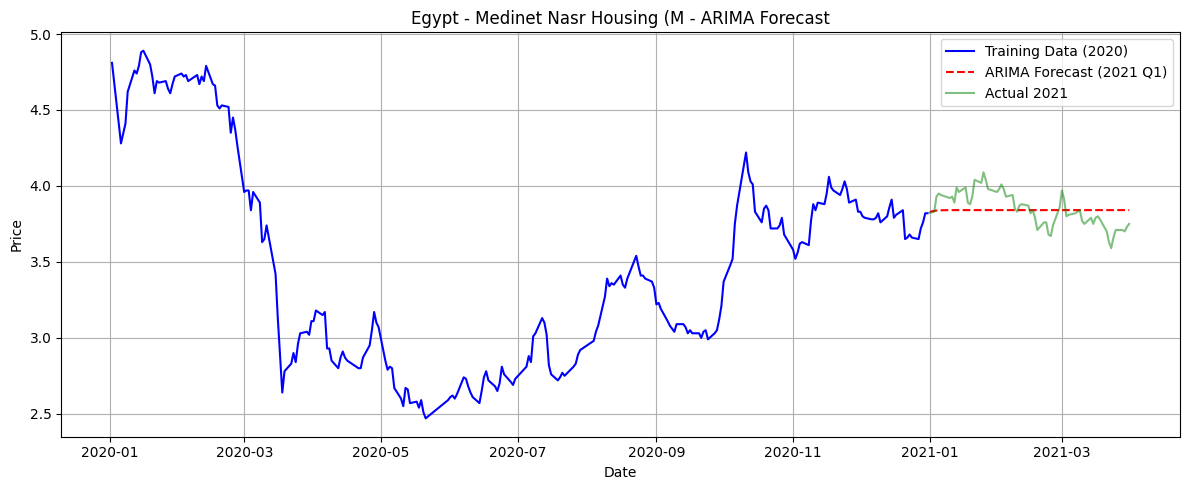

ARIMA Forecast Accuracy for Egypt - Medinet Nasr Housing (M (Q1 2021):
  RMSE : 0.11
  MAPE : 2.43%

 Running ARIMA Forecast for: Brazil - Minerva SABrazil (BEEF


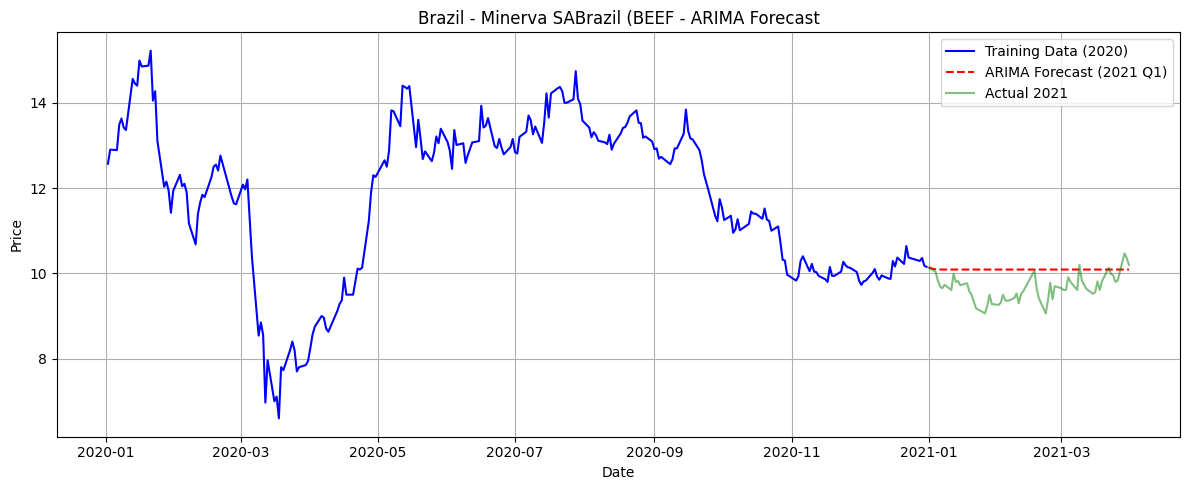

ARIMA Forecast Accuracy for Brazil - Minerva SABrazil (BEEF (Q1 2021):
  RMSE : 0.53
  MAPE : 4.81%

 Running ARIMA Forecast for: Argentina - Pampa Energia SA (P


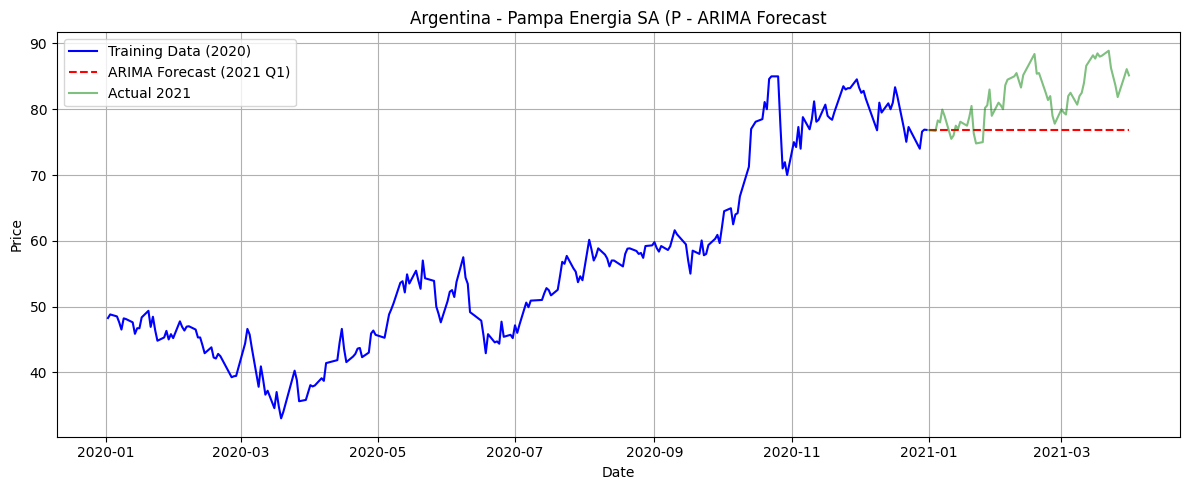

ARIMA Forecast Accuracy for Argentina - Pampa Energia SA (P (Q1 2021):
  RMSE : 6.45
  MAPE : 6.29%

 Running ARIMA Forecast for: Colombia - Cementos Argos SA (C


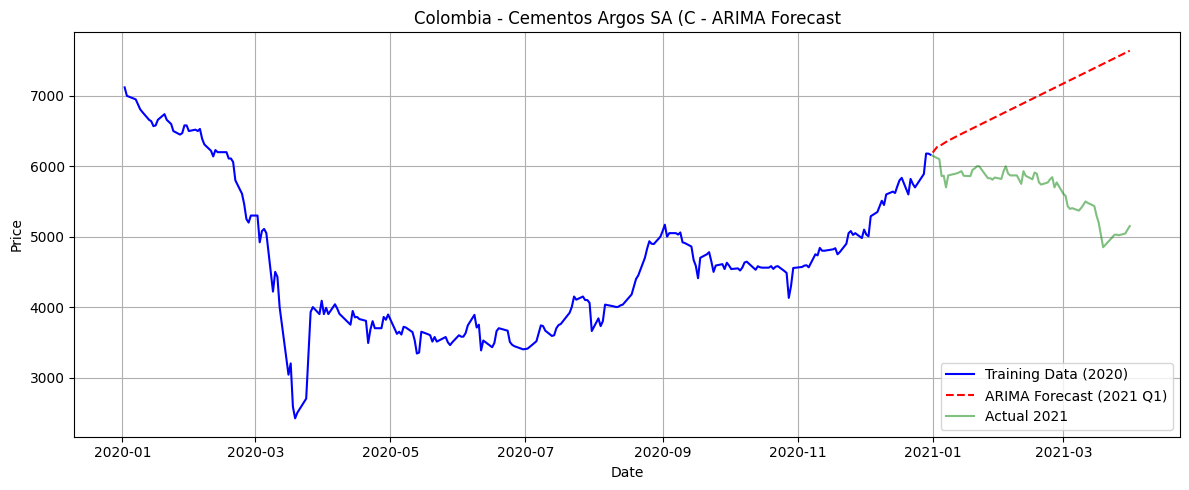

ARIMA Forecast Accuracy for Colombia - Cementos Argos SA (C (Q1 2021):
  RMSE : 1484.08
  MAPE : 23.80%

 Running ARIMA Forecast for: South Africa - Impala Platinum 


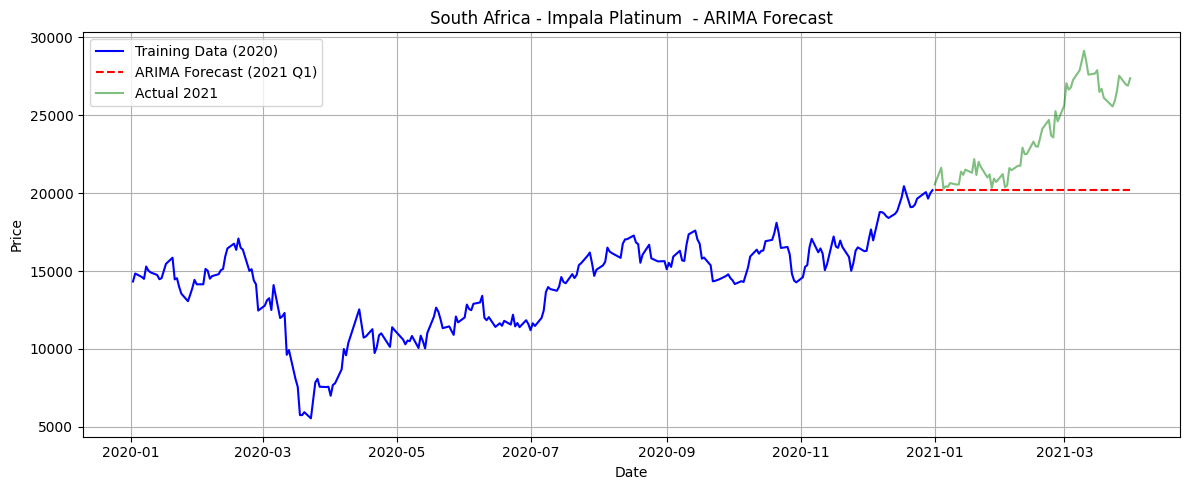

ARIMA Forecast Accuracy for South Africa - Impala Platinum  (Q1 2021):
  RMSE : 4462.69
  MAPE : 13.79%

 Running ARIMA Forecast for: South Korea - Dongkuk Steel Mil


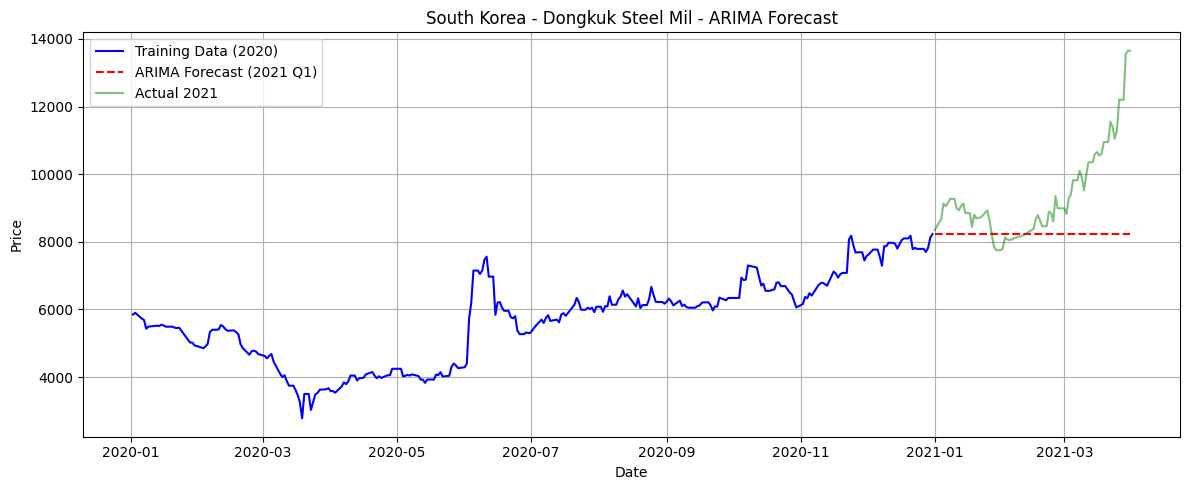

ARIMA Forecast Accuracy for South Korea - Dongkuk Steel Mil (Q1 2021):
  RMSE : 1733.71
  MAPE : 11.26%


In [30]:
# Store results
arima_forecasts = {}
accuracy_summary = []

# Loop over each sheet
for company_name, df in featured_data.items():
    print(f'\n Running ARIMA Forecast for: {company_name}')
    try:
        forecast_series, rmse, mape = arima_forecast(df, company_name=company_name)
        arima_forecasts[company_name] = forecast_series
        accuracy_summary.append({
            'Company': company_name,
            'RMSE': rmse,
            'MAPE': mape
        })
    except Exception as e:
        print(f'❌ Failed for {company_name}: {e}')

### LSTM

LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) designed for sequence prediction, especially time series.<br>
* It remembers long-term dependencies better than vanilla RNNs.<br>
* Works well on financial data when you want to capture complex, nonlinear patterns.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


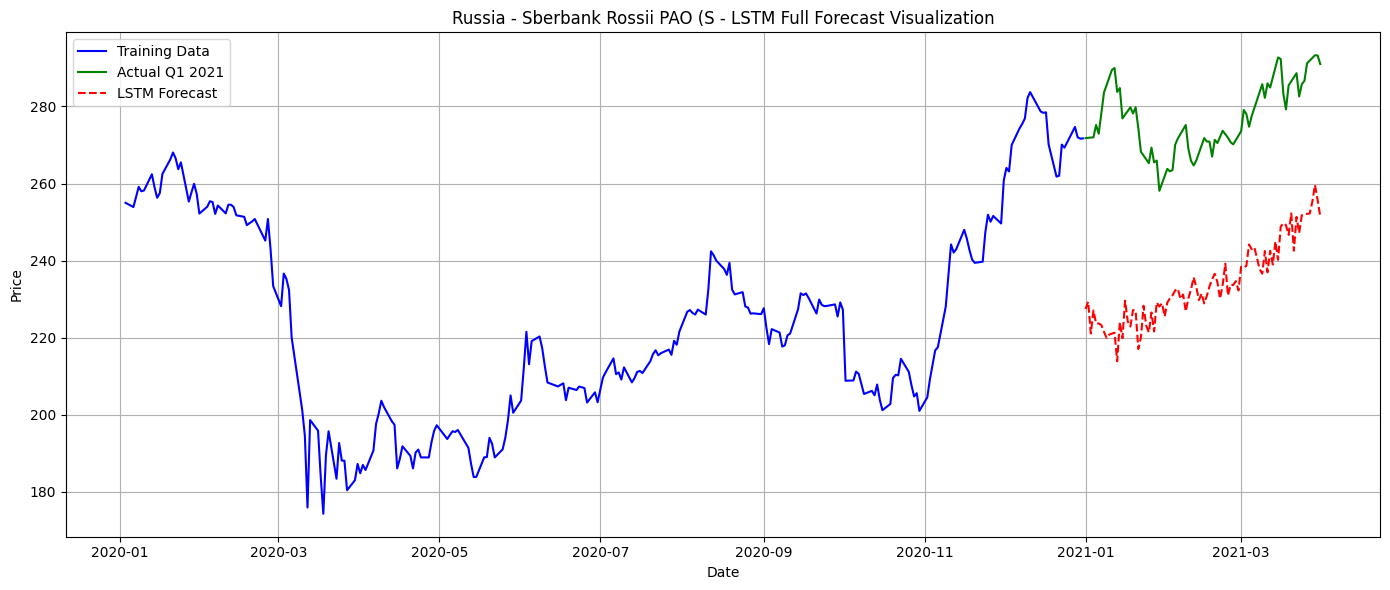

LSTM Forecast Accuracy for Russia - Sberbank Rossii PAO (S:
  RMSE : 43.66
  MAPE : 15.36%


In [32]:
def lstm_forecast(df, company_name='Company', sequence_len=60, forecast_days=90):
    df = df.copy()

    # 1. Preprocess
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df = df.dropna(subset=['Date', 'Price']).set_index('Date').sort_index()
    df = df.asfreq('D')  # Daily frequency
    df['Price'] = df['Price'].interpolate()

    data = df['Price'].values.reshape(-1, 1)

    # 2. Scale
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # 3. Create sequences
    X, y = [], []
    for i in range(sequence_len, len(scaled_data) - forecast_days):
        X.append(scaled_data[i-sequence_len:i])
        y.append(scaled_data[i:i+forecast_days].flatten())
    X, y = np.array(X), np.array(y)

    # 4. Split train/test
    split = int(len(X) * 0.8)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    # 5. Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(forecast_days))
    model.compile(optimizer='adam', loss='mse')

    # 6. Train
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # 7. Predict
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1, forecast_days)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, forecast_days)

    # 8. Evaluate & Plot last prediction
    last_actual = y_test_inv[-1]
    last_pred = y_pred[-1]
    forecast_index = pd.date_range(start=df.index[-forecast_days], periods=forecast_days, freq='D')

    rmse = np.sqrt(mean_squared_error(last_actual, last_pred))
    mape = mean_absolute_percentage_error(last_actual, last_pred) * 100

    # Build full timeline for plotting
    full_actual = scaler.inverse_transform(scaled_data).flatten()
    forecast_start = len(full_actual) - forecast_days
    forecast_dates = pd.date_range(start=df.index[forecast_start], periods=forecast_days, freq='D')

    plt.figure(figsize=(14, 6))
    
    # Plot training data
    plt.plot(df.index[:forecast_start], full_actual[:forecast_start], label='Training Data', color='blue')

    # Plot actual Q1 2021
    plt.plot(df.index[forecast_start:], full_actual[forecast_start:], label='Actual Q1 2021', color='green')

    # Plot forecast
    plt.plot(forecast_dates, last_pred, label='LSTM Forecast', linestyle='--', color='red')

    plt.title(f'{company_name} - LSTM Full Forecast Visualization')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f'LSTM Forecast Accuracy for {company_name}:')
    print(f'  RMSE : {rmse:.2f}')
    print(f'  MAPE : {mape:.2f}%')

    return forecast_index, last_pred, rmse, mape
forecast_index, forecast_values, rmse, mape = lstm_forecast(featured_data[sheets[0]], company_name=sheets[0])

##### LSTM for all sheets/companaies


 Running LSTM Forecast for: Russia - Sberbank Rossii PAO (S
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000017920938EA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


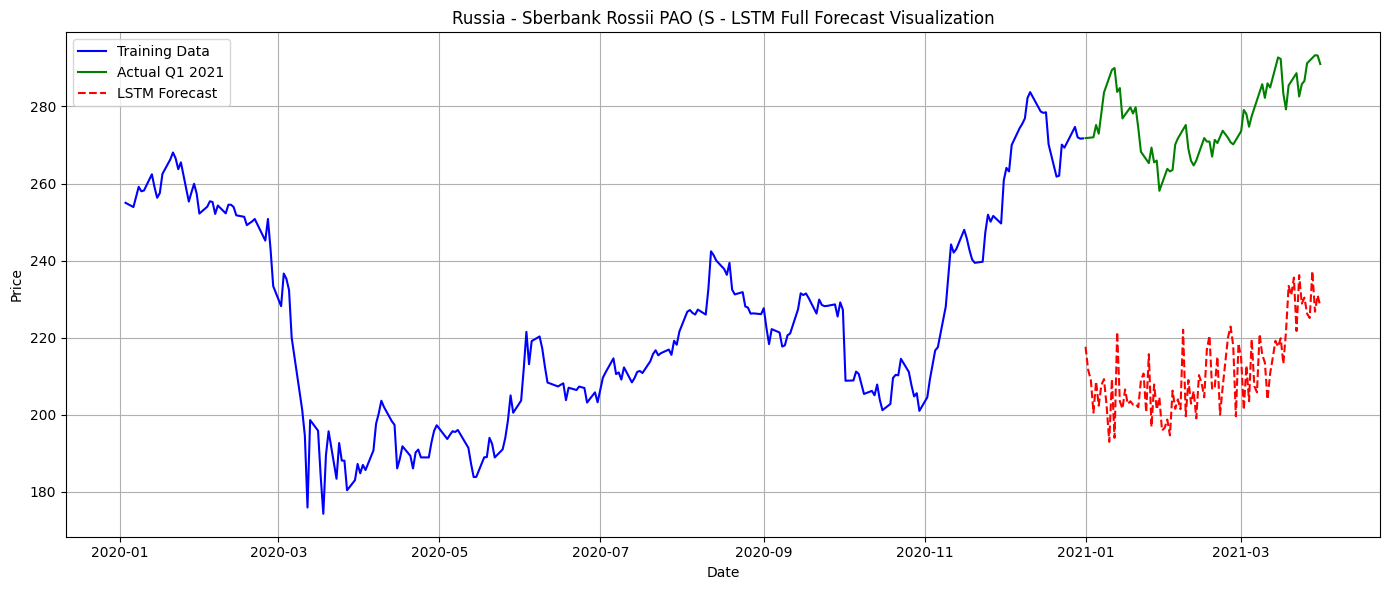

LSTM Forecast Accuracy for Russia - Sberbank Rossii PAO (S:
  RMSE : 66.07
  MAPE : 23.63%

 Running LSTM Forecast for: Turkey - Koc Holding AS (KCHOL)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


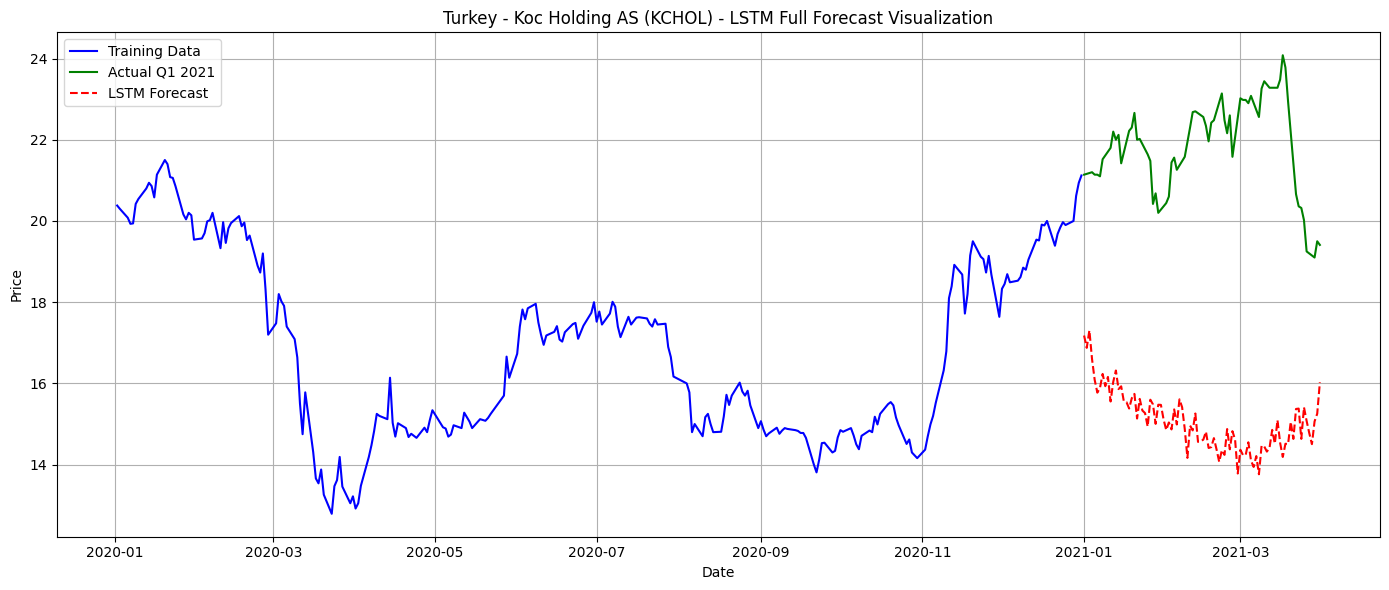

LSTM Forecast Accuracy for Turkey - Koc Holding AS (KCHOL):
  RMSE : 6.97
  MAPE : 30.81%

 Running LSTM Forecast for: Egypt - Medinet Nasr Housing (M
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


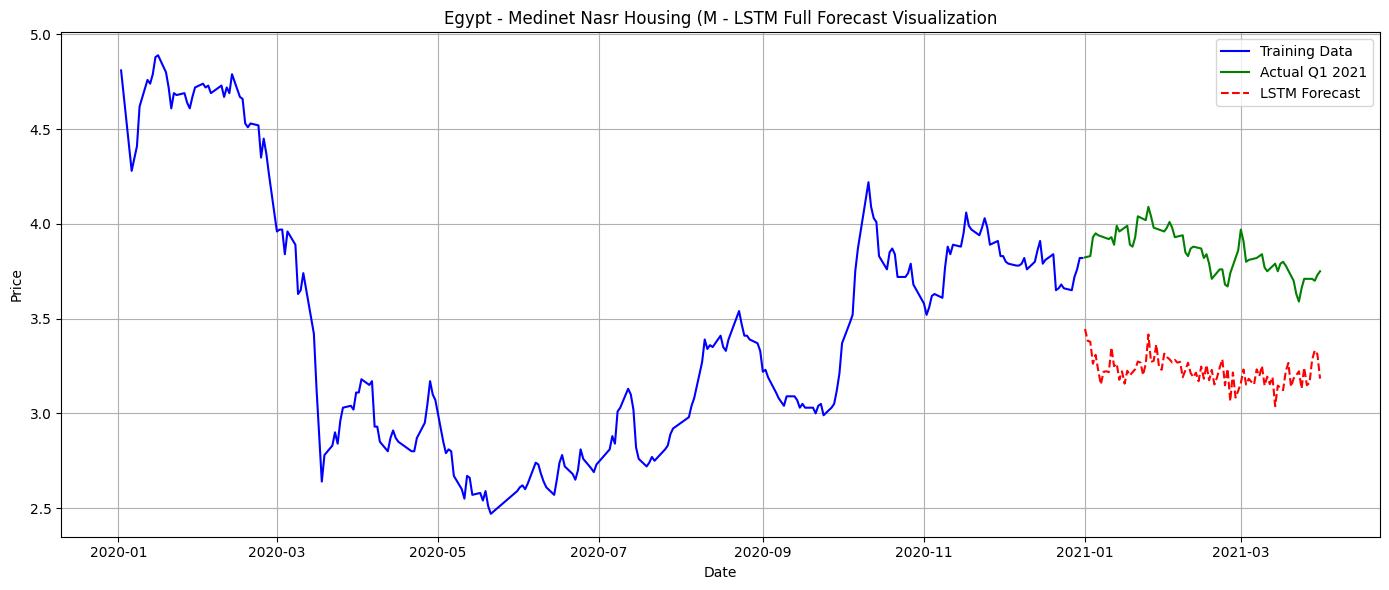

LSTM Forecast Accuracy for Egypt - Medinet Nasr Housing (M:
  RMSE : 0.64
  MAPE : 16.28%

 Running LSTM Forecast for: Brazil - Minerva SABrazil (BEEF
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


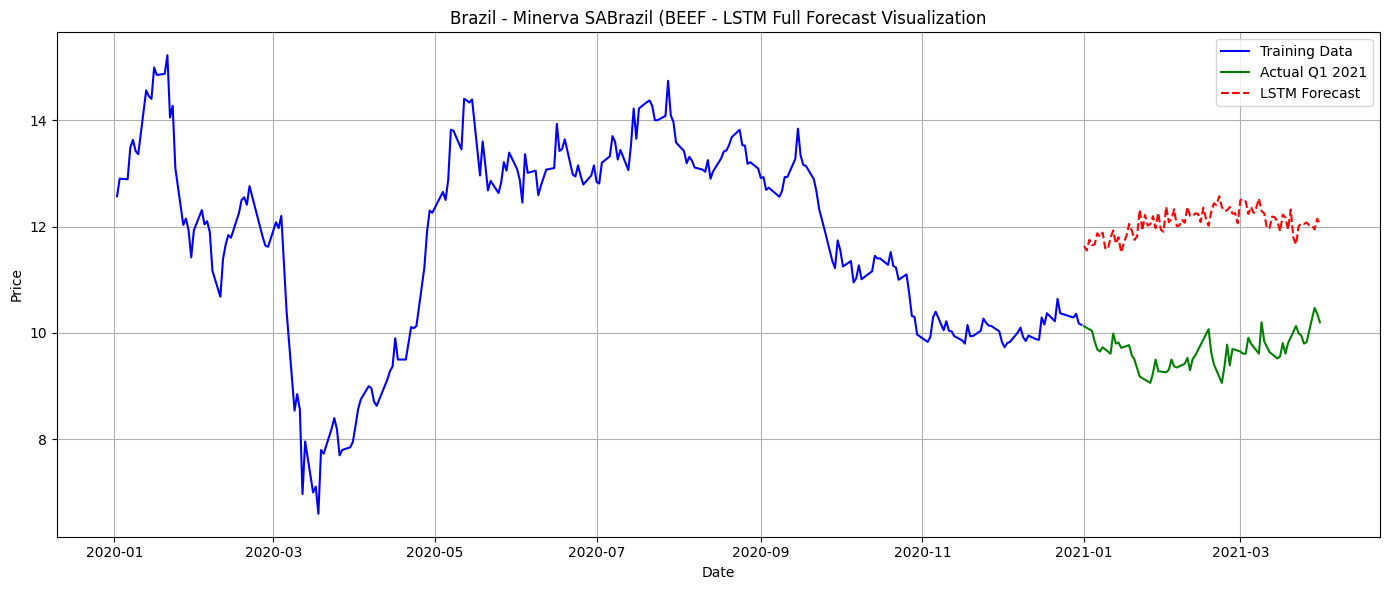

LSTM Forecast Accuracy for Brazil - Minerva SABrazil (BEEF:
  RMSE : 2.46
  MAPE : 25.17%

 Running LSTM Forecast for: Argentina - Pampa Energia SA (P
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


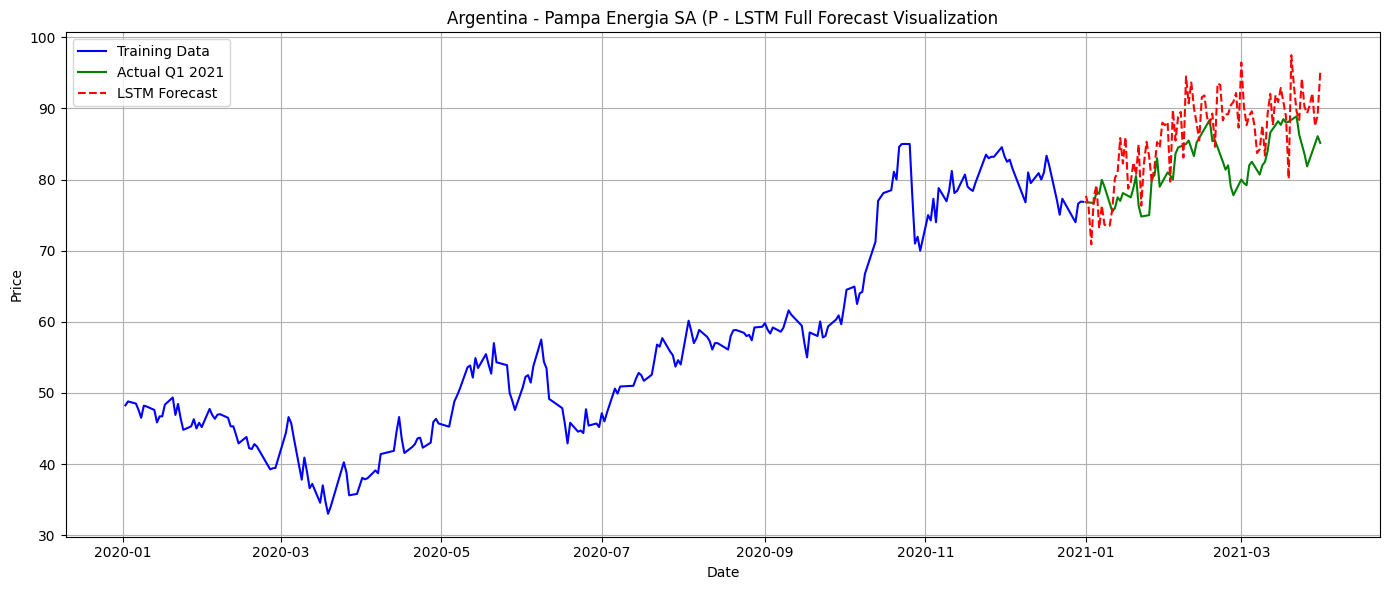

LSTM Forecast Accuracy for Argentina - Pampa Energia SA (P:
  RMSE : 6.33
  MAPE : 6.55%

 Running LSTM Forecast for: Colombia - Cementos Argos SA (C
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


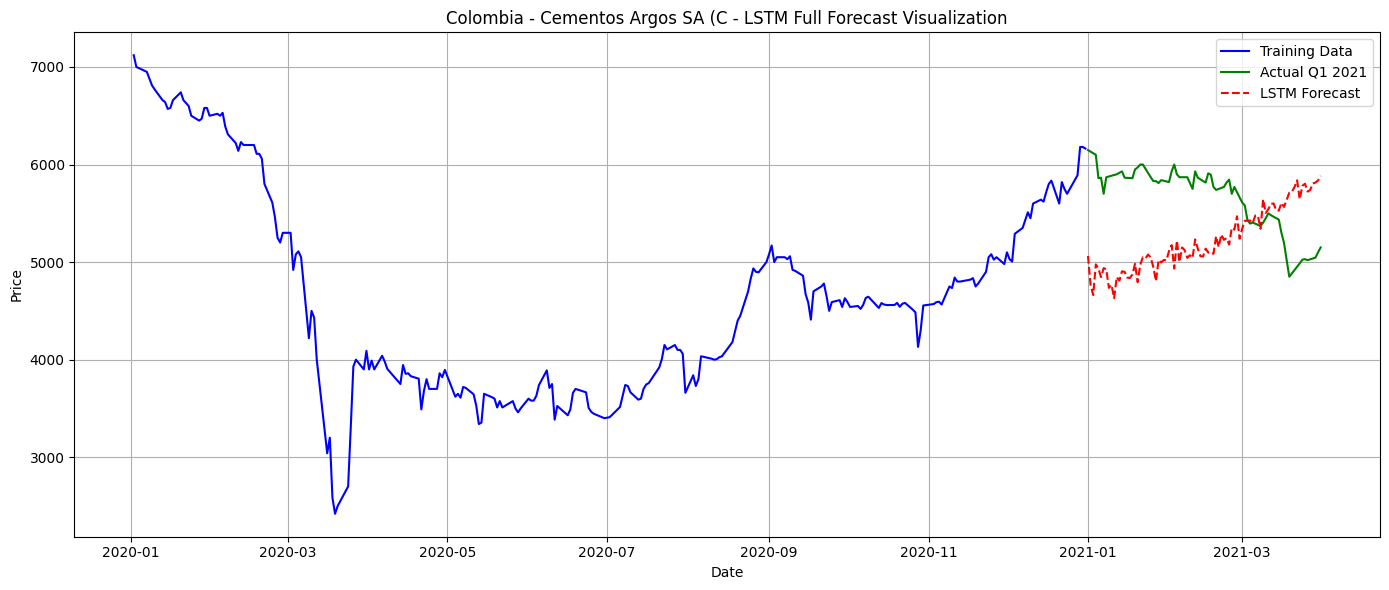

LSTM Forecast Accuracy for Colombia - Cementos Argos SA (C:
  RMSE : 780.84
  MAPE : 12.27%

 Running LSTM Forecast for: South Africa - Impala Platinum 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


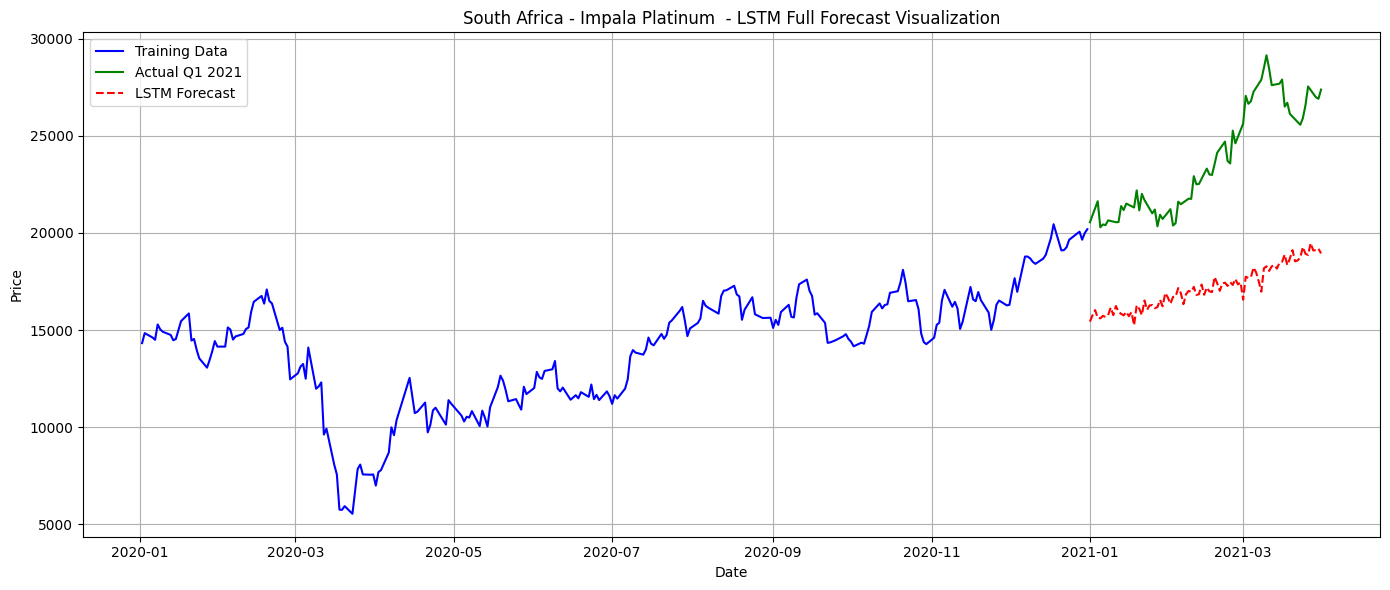

LSTM Forecast Accuracy for South Africa - Impala Platinum :
  RMSE : 6735.91
  MAPE : 26.90%

 Running LSTM Forecast for: South Korea - Dongkuk Steel Mil
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


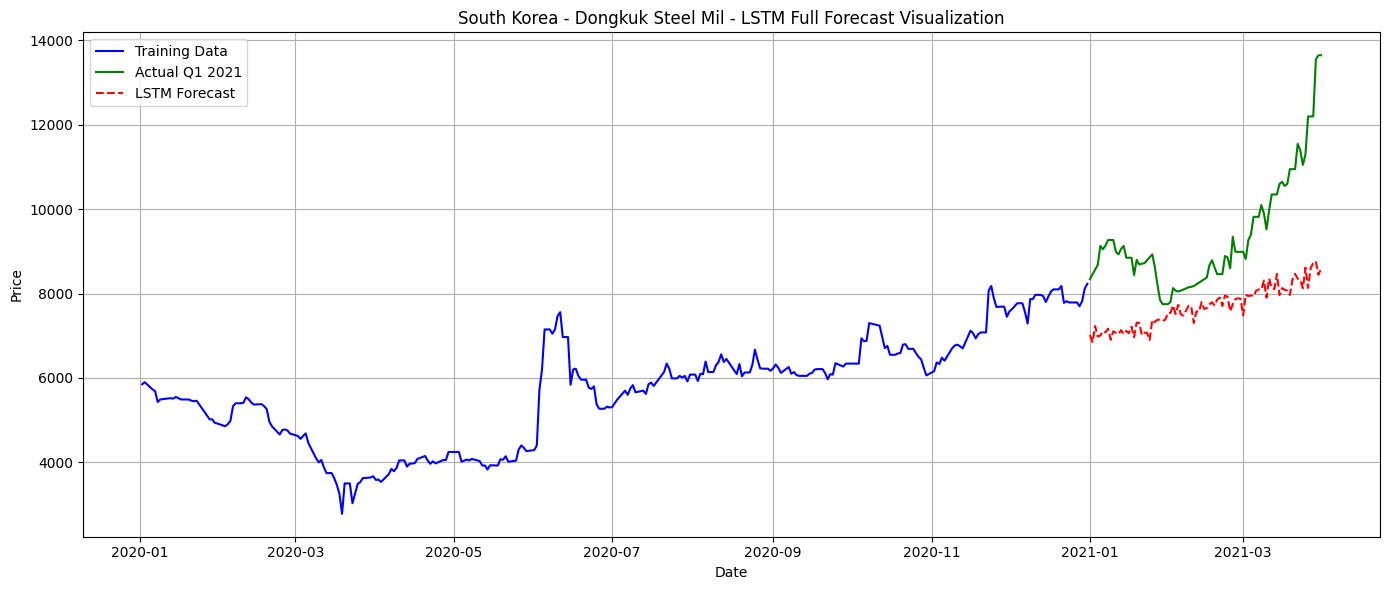

LSTM Forecast Accuracy for South Korea - Dongkuk Steel Mil:
  RMSE : 1871.95
  MAPE : 16.30%


In [33]:
# Storage for results
lstm_forecasts = {}
accuracy_summary = []

# Loop over each company/sheet
for company_name, df in featured_data.items():
    print(f'\n Running LSTM Forecast for: {company_name}')
    try:
        forecast_dates, forecast_values, rmse, mape = lstm_forecast(df, company_name=company_name)
        lstm_forecasts[company_name] = pd.DataFrame({
            'Date': forecast_dates,
            'Forecasted Price': forecast_values
        })
        accuracy_summary.append({
            'Company': company_name,
            'RMSE': rmse,
            'MAPE': mape
        })
    except Exception as e:
        print(f'❌ Error in {company_name}: {e}')

### Buy, Sell, and Hold Signal/Predictions

Using forecast output (daily prices) From LSTM to generate signal. A simple 2% change threshold has been used to generate signal. Which means if future price will increase by 2% then buy conversely if future price falls by 2% then sell else hold. 

In [34]:
def generate_signals(forecast_df, threshold=0.02):
    """
    Generate BUY, HOLD, SELL signals based on forecast price changes.

    forecast_df: DataFrame with columns ['Date', 'Forecasted Price']
    threshold: percentage change to trigger BUY or SELL
    """
    df = forecast_df.copy()
    df['Next_Price'] = df['Forecasted Price'].shift(-1)
    df['Pct_Change'] = (df['Next_Price'] - df['Forecasted Price']) / df['Forecasted Price']
    
    def decide(change):
        if pd.isna(change):
            return 'HOLD'
        if change >= threshold:
            return 'BUY'
        elif change <= -threshold:
            return 'SELL'
        else:
            return 'HOLD'
    
    df['Signal'] = df['Pct_Change'].apply(decide)
    return df[['Date', 'Forecasted Price', 'Signal']]


In [36]:
signals = generate_signals(lstm_forecasts[sheets[0]], threshold=0.02)
print(signals.head())

        Date  Forecasted Price Signal
0 2021-01-01        217.619888   SELL
1 2021-01-02        211.623505   HOLD
2 2021-01-03        209.075104   SELL
3 2021-01-04        200.528122    BUY
4 2021-01-05        208.626846   SELL


##### Visualize Signals

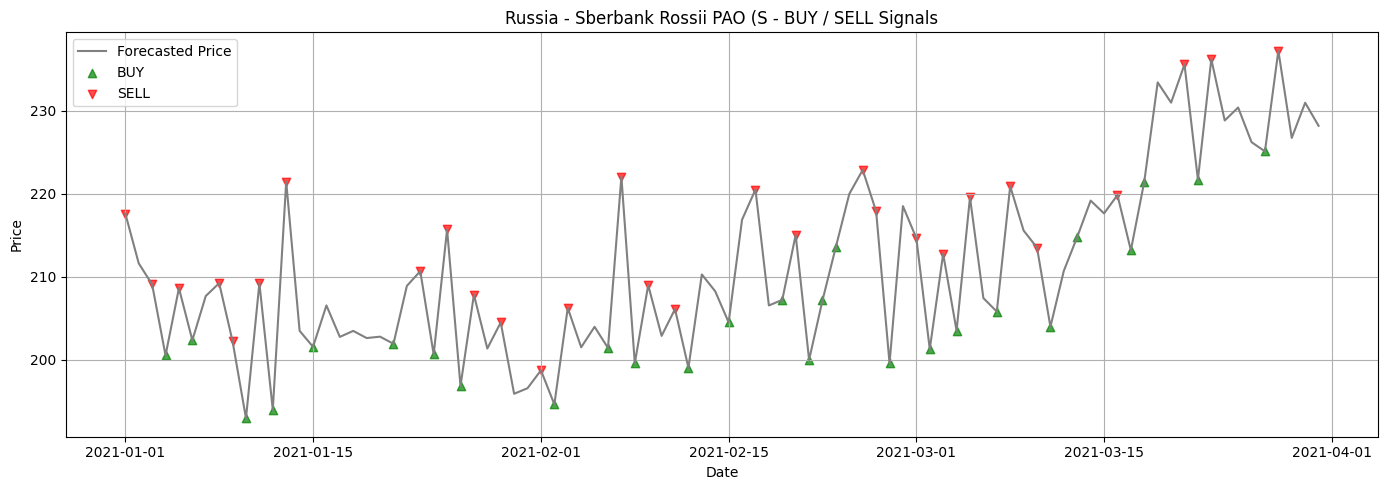

In [37]:
def plot_signals(signals_df, company_name='Company'):
    plt.figure(figsize=(14, 5))
    plt.plot(signals_df['Date'], signals_df['Forecasted Price'], label='Forecasted Price', color='gray')

    buy_signals = signals_df[signals_df['Signal'] == 'BUY']
    sell_signals = signals_df[signals_df['Signal'] == 'SELL']

    plt.scatter(buy_signals['Date'], buy_signals['Forecasted Price'], marker='^', color='green', label='BUY', alpha=0.7)
    plt.scatter(sell_signals['Date'], sell_signals['Forecasted Price'], marker='v', color='red', label='SELL', alpha=0.7)

    plt.title(f'{company_name} - BUY / SELL Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_signals(signals, company_name=sheets[0])

##### Signals for all companies.

In [38]:
all_signals = {}

for company_name, forecast_df in lstm_forecasts.items():
    try:
        print(f'📈 Generating signals for {company_name}...')
        signals_df = generate_signals(forecast_df, threshold=0.02)  # 2% threshold
        all_signals[company_name] = signals_df
    except Exception as e:
        print(f' Error generating signals for {company_name}: {e}')

📈 Generating signals for Russia - Sberbank Rossii PAO (S...
📈 Generating signals for Turkey - Koc Holding AS (KCHOL)...
📈 Generating signals for Egypt - Medinet Nasr Housing (M...
📈 Generating signals for Brazil - Minerva SABrazil (BEEF...
📈 Generating signals for Argentina - Pampa Energia SA (P...
📈 Generating signals for Colombia - Cementos Argos SA (C...
📈 Generating signals for South Africa - Impala Platinum ...
📈 Generating signals for South Korea - Dongkuk Steel Mil...


### System effectiveness using the Bollinger bands.

##### Capital Returns (from BUY/SELL signals) Evaluation
We simulate portfolio value over time and calculate:

- Net Return = Final Portfolio - Initial Cash

- Return % = Net Return ÷ Initial Cash

* Max Drawdown (worst dip in value)

In [39]:
def evaluate_strategy(signals_df, initial_cash=10000):
    df = signals_df.copy()
    df['Position'] = 0
    df['Cash'] = initial_cash
    df['Holdings'] = 0
    df['Total Value'] = initial_cash

    holding = 0
    cash = initial_cash
    values = []

    for i in range(len(df)):
        price = df.loc[i, 'Forecasted Price']
        signal = df.loc[i, 'Signal']

        if signal == 'BUY' and cash >= price:
            holding += 1
            cash -= price
        elif signal == 'SELL' and holding > 0:
            holding -= 1
            cash += price

        df.loc[i, 'Position'] = holding
        df.loc[i, 'Cash'] = cash
        df.loc[i, 'Holdings'] = holding * price
        df.loc[i, 'Total Value'] = cash + (holding * price)
        values.append(cash + (holding * price))

    # 📊 Evaluation Metrics
    final_value = df['Total Value'].iloc[-1]
    net_profit = final_value - initial_cash
    return_pct = (net_profit / initial_cash) * 100
    max_drawdown = (np.max(values) - np.min(values)) / np.max(values) * 100

    return {
        'Final Value': final_value,
        'Net Profit': net_profit,
        'Return %': return_pct,
        'Max Drawdown %': max_drawdown
    }, df


##### Bollinger Bands Effectiveness

In [41]:
def bollinger_alignment_score(df):
    lower_hits = ((df['Signal'] == 'BUY') & (df['Forecasted Price'] <= df['Lower Band'])).sum()
    upper_hits = ((df['Signal'] == 'SELL') & (df['Forecasted Price'] >= df['Upper Band'])).sum()
    total_signals = ((df['Signal'] == 'BUY') | (df['Signal'] == 'SELL')).sum()
    
    if total_signals == 0:
        return 0.0  # avoid division by zero
    
    aligned = lower_hits + upper_hits
    alignment_score = (aligned / total_signals) * 100  # percentage of good signals
    return alignment_score

def add_bollinger_bands(df, window=20):
    df = df.copy()
    df['MA'] = df['Forecasted Price'].rolling(window).mean()
    df['STD'] = df['Forecasted Price'].rolling(window).std()
    df['Upper Band'] = df['MA'] + (2 * df['STD'])
    df['Lower Band'] = df['MA'] - (2 * df['STD'])
    return df

##### Evaluate One Company

In [44]:
company = sheets[0]
Eval_signals = all_signals[sheets[0]]
Eval_signals = add_bollinger_bands(Eval_signals)

metrics, backtest_df = evaluate_strategy(Eval_signals)
alignment = bollinger_alignment_score(Eval_signals)

print(f" {company} Performance:")
print(f"  Final Value      : {metrics['Final Value']:.2f}")
print(f"  Net Profit       : {metrics['Net Profit']:.2f}")
print(f"  Return %         : {metrics['Return %']:.2f}%")
print(f"  Max Drawdown %   : {metrics['Max Drawdown %']:.2f}%")
print(f"🎯 Bollinger Signal Alignment: {alignment:.2f}%")


 Russia - Sberbank Rossii PAO (S Performance:
  Final Value      : 10367.37
  Net Profit       : 367.37
  Return %         : 3.67%
  Max Drawdown %   : 3.80%
🎯 Bollinger Signal Alignment: 3.57%


##### Evaluate all companies

In [45]:
summary_results = []

for company, signals_df in all_signals.items():
    try:
        # Step 1: Add Bollinger Bands
        signals_df = add_bollinger_bands(signals_df)

        # Step 2: Evaluate strategy (capital return)
        metrics, backtest_df = evaluate_strategy(signals_df)

        # Step 3: Evaluate Bollinger Band alignment
        alignment = bollinger_alignment_score(signals_df)

        # Collect all results
        summary_results.append({
            'Company': company,
            'Final Value': round(metrics['Final Value'], 2),
            'Net Profit': round(metrics['Net Profit'], 2),
            'Return %': round(metrics['Return %'], 2),
            'Max Drawdown %': round(metrics['Max Drawdown %'], 2),
            'Bollinger Alignment %': round(alignment, 2)
        })

    except Exception as e:
        print(f" Skipped {company} due to error: {e}")

# Create DataFrame
evaluation_df = pd.DataFrame(summary_results)

# Display sorted by Return %
evaluation_df.sort_values(by='Return %', ascending=False, inplace=True)
print(evaluation_df)

                           Company  Final Value  Net Profit  Return %  \
7  South Korea - Dongkuk Steel Mil     16192.35     6192.35     61.92   
5  Colombia - Cementos Argos SA (C     13145.60     3145.60     31.46   
0  Russia - Sberbank Rossii PAO (S     10367.37      367.37      3.67   
4  Argentina - Pampa Energia SA (P     10187.69      187.69      1.88   
1  Turkey - Koc Holding AS (KCHOL)     10016.16       16.16      0.16   
3  Brazil - Minerva SABrazil (BEEF     10002.64        2.64      0.03   
2  Egypt - Medinet Nasr Housing (M     10001.76        1.76      0.02   
6  South Africa - Impala Platinum      10000.00        0.00      0.00   

   Max Drawdown %  Bollinger Alignment %  
7           38.24                  12.82  
5           23.93                  11.11  
0            3.80                   3.57  
4            1.84                   4.84  
1            0.16                   6.12  
3            0.04                  10.00  
2            0.02                   7.89 

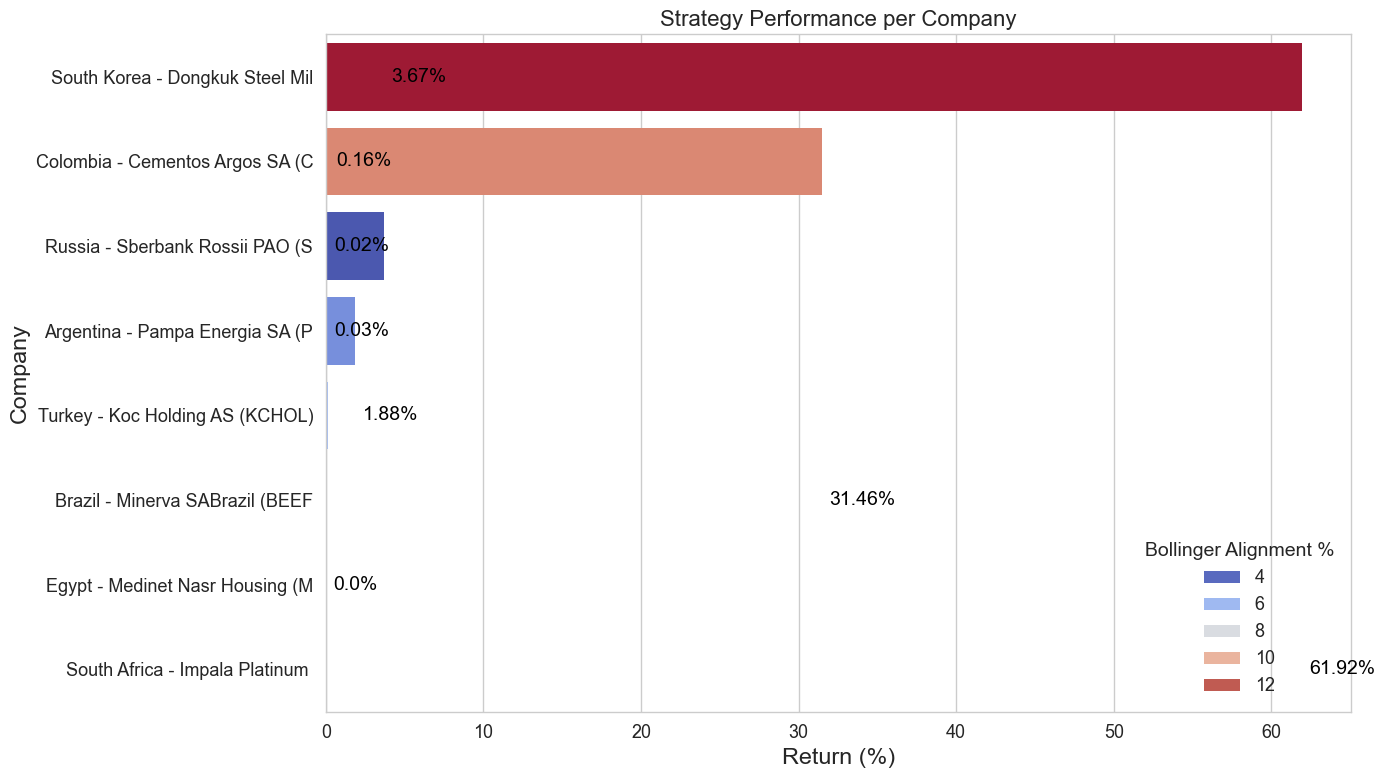

In [54]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

# Sort by Return %
evaluation_df_sorted = evaluation_df.sort_values(by='Return %', ascending=False)

# Barplot of Return % with color based on Bollinger Alignment
bar = sns.barplot(
    x='Return %', 
    y='Company', 
    data=evaluation_df_sorted,
    palette=sns.color_palette("coolwarm", as_cmap=True),
    hue='Bollinger Alignment %',
    dodge=False
)

# Annotate bars
for index, row in evaluation_df_sorted.iterrows():
    bar.text(row['Return %'] + 0.5, index, f"{row['Return %']}%", color='black', va='center')

plt.title("Strategy Performance per Company", fontsize=16)
plt.xlabel("Return (%)")
plt.ylabel("Company")
plt.legend(title='Bollinger Alignment %', loc='lower right')
plt.tight_layout()
plt.show()
